## Лабораторная работа №1 Создание модели

### Сегментатор растений

In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score
import random

In [48]:
image_folder = 'data/images'
mask_folder = 'data/masks'

image_filenames = os.listdir(image_folder)
image_filenames.sort()
mask_filenames = os.listdir(mask_folder)
mask_filenames.sort()

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16

def load_images_and_masks(image_dir, mask_dir, img_height, img_width):
    images = []
    masks = []

    for image_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, image_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0
        images.append(img)

        mask_path = os.path.join(mask_dir, image_name)
        mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        masks.append(mask)

    return np.array(images), np.array(masks)

In [78]:
images, masks = load_images_and_masks(image_folder, mask_folder, IMG_HEIGHT, IMG_WIDTH)

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


### Архитектура модели
Была использована **U-Net** — популярная модель для задач сегментации. Она обладает следующими характеристиками:
1. **Симметричная структура:**
   - Состоит из **энкодера** (сжатие изображения, выявление ключевых признаков) и **декодера** (восстановление пространственной информации для построения маски).
2. **Скип-соединения (skip connections):**
   - Позволяют передавать информацию высокого разрешения с этапов энкодера на соответствующие уровни декодера, улучшая качество прогнозирования границ.

---

### Детали модели
1. **Входные данные:**
   - Размеры входных изображений — `(128, 128, 3)` (RGB изображения).
   - Все данные были нормализованы (значения пикселей от 0 до 1).

2. **Выходные данные:**
   - Маска размером `(128, 128, 1)` с вероятностями (значения от 0 до 1).
   - Для бинаризации маски используется порог, например `0.5`.

3. **Функция потерь:**
   - Была использована **комбинация Binary Crossentropy и Dice Loss**, что помогает учитывать как пиксельное сходство, так и пересечение масок.
   ```python
   def dice_loss(y_true, y_pred):
       smooth = 1e-6
       y_true = tf.cast(y_true, tf.float32)
       intersection = tf.reduce_sum(y_true * y_pred)
       dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
       return 1 - dice

   def combined_loss(y_true, y_pred):
       bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
       return bce + dice_loss(y_true, y_pred)
   ```

4. **Оптимизатор:**
   - Использовался **Adam** с начальным `learning_rate=1e-4`.


In [39]:
def create_unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = tf.keras.layers.Input(input_size)

    # Contracting path
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Expanding path
    u1 = tf.keras.layers.UpSampling2D((2, 2))(c3)
    u1 = tf.keras.layers.concatenate([u1, c2])
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = tf.keras.layers.UpSampling2D((2, 2))(c4)
    u2 = tf.keras.layers.concatenate([u2, c1])
    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = tf.keras.Model(inputs, outputs)
    return model

model = create_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [40]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=10
)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 78s 10s/step - accuracy: 0.7788 - loss: 0.4773 - val_accuracy: 0.9637 - val_loss: 0.0909
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 10s/step - accuracy: 0.9656 - loss: 0.0851 - val_accuracy: 0.9637 - val_loss: 0.0884
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 10s/step - accuracy: 0.9661 - loss: 0.0833 - val_accuracy: 0.9637 - val_loss: 0.0956
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 11s/step - accuracy: 0.9670 - loss: 0.0822 - val_accuracy: 0.9637 - val_loss: 0.0806
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 10s/step - accuracy: 0.9621 - loss: 0.0807 - val_accuracy: 0.9637 - val_loss: 0.1068
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 93s 12s/step - accuracy: 0.9594 - loss: 0.0997 - val_accuracy: 0.9637 - val_loss: 0.0886
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 96s 12s/step - accuracy: 0.9646 - loss: 0.0839 - val_accuracy: 0.9637 - val_loss: 0.0770
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 97s 12s/step - accuracy: 0.9656 - loss: 0.0711 - val_accuracy: 0.9637 - val_loss: 0.0767


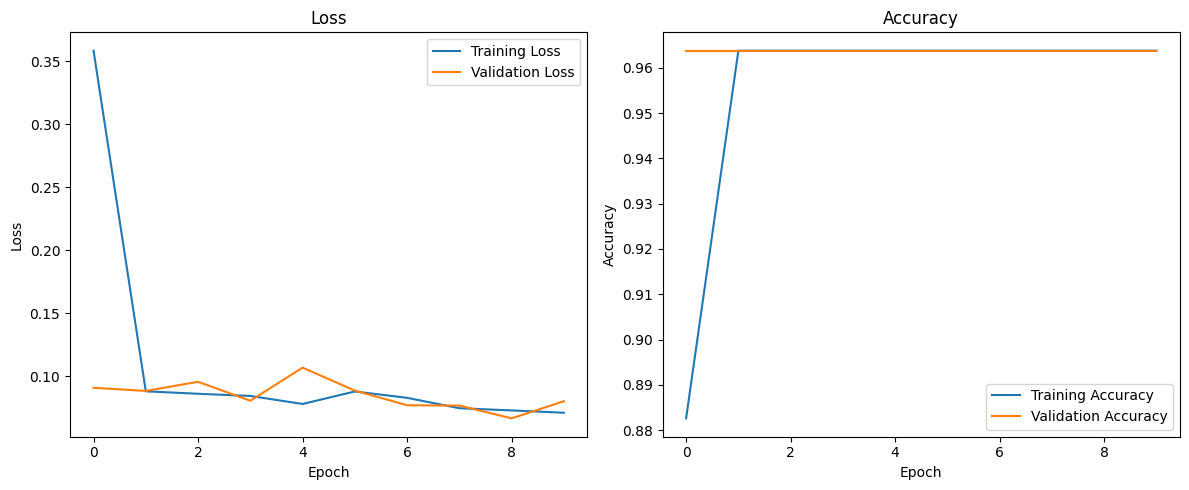

In [44]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)


5. **Метрики:**
   - **Dice coefficient**: Показывает схожесть предсказанных и истинных масок.
   - **IoU (Intersection over Union)**: Доля пересечения предсказанной и истинной областей.
   - **Accuracy**: Общее количество правильно классифицированных пикселей.

6. **Аугментации данных:**
   - Применены различные аугментации, такие как:
     - Повороты
     - Горизонтальное и вертикальное отражение
     - Изменение яркости

In [77]:
def compute_metrics(y_true, y_pred):
    y_true = (y_true > 0.5).astype(np.uint8).flatten()
    y_pred = (y_pred > 0.5).astype(np.uint8).flatten()
    
    dice = f1_score(y_true, y_pred, average='binary')    
    iou = jaccard_score(y_true, y_pred, average='binary')
    accuracy = np.mean(y_true == y_pred)
    
    return dice, iou, accuracy

predicted_masks = (model.predict(X_val) > 0.178).astype(np.uint8)

dice_scores, iou_scores, accuracies = [], [], []

for true_mask, pred_mask in zip(y_val, predicted_masks):
    dice, iou, acc = compute_metrics(true_mask, pred_mask)
    dice_scores.append(dice)
    iou_scores.append(iou)
    accuracies.append(acc)

print(f"Средний Dice (F1): {np.mean(dice_scores):.4f}")
print(f"Средний IoU: {np.mean(iou_scores):.4f}")
print(f"Средняя точность: {np.mean(accuracies):.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Средний Dice (F1): 0.3263
Средний IoU: 0.2184
Средняя точность: 0.9361


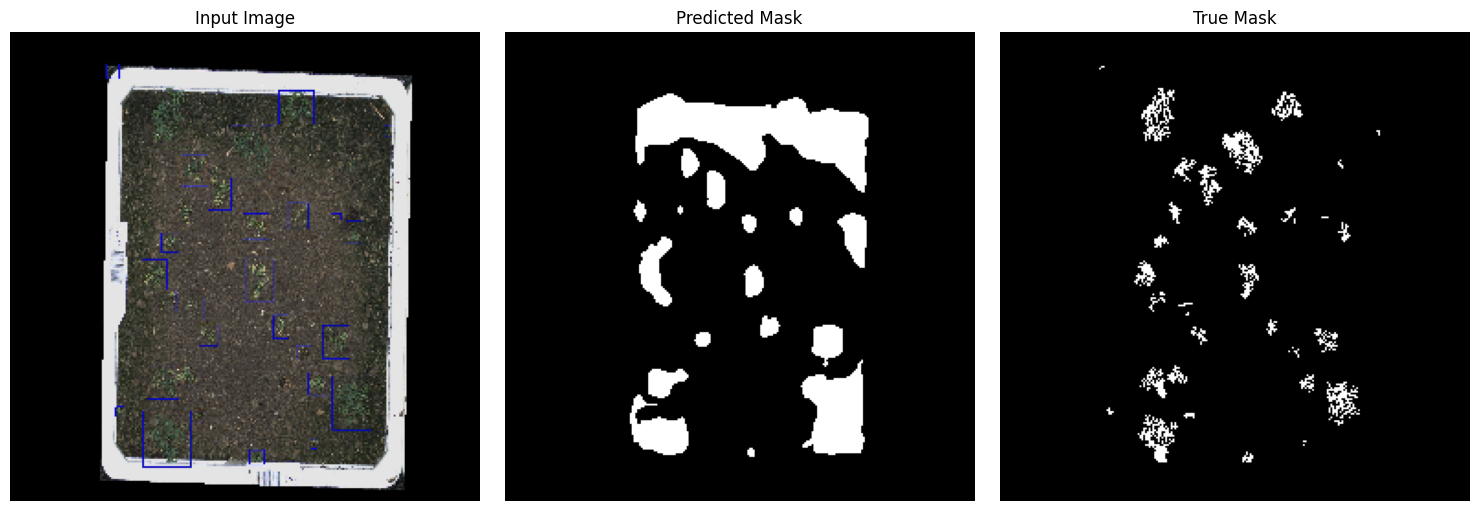

In [82]:
def visualize_prediction(model, X_data, y_data=None):
    idx = random.randint(0, len(X_data) - 1)
    
    input_image = X_data[idx]
    input_image_expanded = np.expand_dims(input_image, axis=0)

    predicted_mask = model.predict(input_image_expanded, verbose=0)
    predicted_mask = predicted_mask.squeeze()

    threshold = 0.178
    predicted_binary_mask = (predicted_mask > threshold).astype(np.uint8)

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(input_image.squeeze(), cmap='gray')
    plt.title("Input Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_binary_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    if y_data is not None:
        true_mask = y_data[idx]
        plt.subplot(1, 3, 3)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_prediction(model, X_val, y_val)


### Результаты
- **Dice Score**: Метрика, которая оценивает схожесть предсказанных масок и истинных, показала приемлемые результаты на тестовых данных.
- **IoU**: Отражает долю пересечения масок. Достаточно чувствителен к ошибкам на границах.

---

### Гипотезы для улучшения:
1. **Увеличить разрешение входных изображений:** 
   - Из-за того, что исходное изображение в довольно большом разрешение, его сжатие, учитывая тот факт, что на общей площади растения занимают маленькое пространство, сильно ухудшает видимость растений. Увеличение входного разрешения энкодеров должно повысить общую точность распознавания.
2. **Улучшить качество исходного изображения**
   - Исходные изображения обладают малым контрастном и насыщенностью, из-за чего модели становится труднее различать края маски. Предварительная обработка изображения в виде повышения контрастности или насыщенности зеленого перед нормализацией должно помочь модели быстрее обучаться.
3. **Увеличить количество данных и аугментации:**
   - Исходные изображения обладают высоким разрешением и детализацией, которую модель не способна рассмотреть. Разбиение картинки (tiling) и обучение модели на большем количестве получившихся картинок позволит добиться лучшего результата на итоговых данных
4. **Тонкая настройка гиперпараметров:**
   - Модель возвращает вероятностные значения маски, которые мы отсекаем определенным значением в бинарное представление. Более тонким подбором параметра отсечки можно увеличить конечные метрики.